<img src="./mbit-logo.png" align="right" style="float" width="55">
<font color="#CA3532"><h1 align="left">EJERCICIO: APRENDIZAJE REFORZADO</h1></font>
<font color="#CA3532"><h2 align="left">Máster en Big Data, Cloud & Analytics 2019-2020</h2></font>
<font color="#6E6E6E"><h4 align="left">Carlos Alfonsel <a> carlos.alfonsel@mbitschool.com </a> </h4></font> 

Ejecutado en una VM Ubuntu 16.04 con un entorno `env_rl` con las siguientes librerias instaladas:

- `gym`==0.17.2
- `keras`==2.2.4
- `keras-rl`==0.4.2
- `tensorflow`==1.9.0

# Reinforcement Learning

De: https://github.com/JannesKlaas/sometimes_deep_sometimes_learning

## An interactive notebook training `Keras` to play `Catch`

This is an interactive version of [Eder Santana's](http://edersantana.github.io/) [Keras plays catch, a single file Reinforcement Learning example](https://edersantana.github.io/articles/keras_rl/). The first interactive version of the original code was written by [cadurosar](https://gist.github.com/cadurosar/bd54c723c1d6335a43c8). I added comments and explanations, following the explanation laid out in [Demystifying Deep Reinforcement Learning](http://neuro.cs.ut.ee/demystifying-deep-reinforcement-learning/) by [Tambet Matiisen](https://github.com/tambetm/). Please visit all the aforementioned authors websites for more information and give them credit for doing all the heavy lifting. This code is realeased under an MIT license, but please be aware that Google has the patent for `Q-Learning`.


## The Task

`Catch` is a very simple arcade game, which you might have played as a child. Fruits are falling from the top of the screen and the player has to catch them with a basket. For every fruit caught, the player gets a point. For every fruit lost, the player looses a point. Our goal here is to let the computer play `Catch` by itself.

When playing `Catch`, the player has to decide between 3 possible actions. The player can move the basket to the left, to the right, or stay put. The basis for this decision is the current state of the game, the position of the fruit and the position of the basket, which are both visible on the screen. Our goal is therefore to create a model, which, given the content of the game screen, chooses the action which leads to the highest score possible.

This task could be framed as a simple classification problem. We could collect training data by letting expert human players play lots of games and then train a model on choosing the 'correct' action that mirrors the expert players. This is not how humans learn however. Humans can learn a game like catch by themselves, without guidiance. This is very useful. Imagine you would have to hire a bunch of experts to perform a task thousands of times everytime you wanted to learn something as simple as `Catch`. It would be very expensive and very slow. Here, we are going to demonstrate a technique called reinforcement learning, where the model learns from experience, rather than labeled training data.

In [1]:
# Firstly, we import some libraries

import json                               # json for loading and saving the model (optional)
import matplotlib.pyplot   as plt         # matplotlib for rendering
import numpy               as np          # numpy for handeling matrix operations
import time                               # time, to, well... keep track of time
import seaborn                            # seaborn for rendering

from   PIL                 import Image   # Python image library for rendering
from   IPython             import display # iPython display for making sure we can render the frames

# Keras is a deep learning library
import keras
from   keras.models        import model_from_json
from   keras.models        import Sequential
from   keras.layers        import Dense, Activation, Flatten
from   keras.optimizers    import sgd, Adam

# Setup matplotlib so that it runs nicely in iPython
%matplotlib inline
# Setting up seaborn
seaborn.set()

# Gym is a toolkit for developing and comparing reinforcement learning algorithms
import gym
from   gym.spaces          import Discrete, Box


Using TensorFlow backend.
/home/osboxes/anaconda3/envs/env_rl/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/osboxes/anaconda3/envs/env_rl/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/osboxes/anaconda3/envs/env_rl/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/osboxes/ana

## RE-BUILDING THE MODEL USING `GYM` (MBIT RL EXERCISE)

### ENVIRONMENT DEFINITION WITH `GYM`

In [2]:
import gym
from   gym.spaces import Discrete, Box

class myCatchEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, grid_size = 10):
        self.grid_size    = grid_size
        self.action_space = Discrete(3)
        self.reset()
        
    def reset(self):
        n = np.random.randint(0, self.grid_size - 1, size = 1)[0]
        m = np.random.randint(1, self.grid_size - 1, size = 1)[0]
        self.state = np.array([0, n, m])

    def _update_state(self, action):
        state = self.state
        if action == 0:
            action = -1   # move to the left
        elif action == 1:
            action = 0    # stand still
        else:
            action = 1    # move to the right
        f0, f1, basket = state
        new_basket = min(max(1, basket + action), self.grid_size - 1)
        
        # Adding random wind to our game
        df1 = np.random.randint(0, 3, 1)
        if df1 == 0:
            f1 -= 1
        elif df1 == 2:
            f1 += 1
        else:
            pass
        if f1 > self.grid_size - 1:
            f1 = self.grid_size - 1
        if f1 < 0:
            f1 = 0
        
        f0 += 1
        out = np.asarray([f0, f1, new_basket])
        self.state = out

    def _draw_state(self):
        im_size = (self.grid_size,) * 2
        state   = self.state
        canvas  = np.zeros(im_size)
        canvas[state[0], state[1]] = 1            # fruit drawing
        canvas[-1, state[2] - 1:state[2] + 2] = 1 # basket drawing
        return canvas

    def _get_reward(self):
        fruit_row, fruit_col, basket = self.state
        if fruit_row == self.grid_size - 1:
            if abs(fruit_col - basket) <= 1:
                return 1  # positive reward if fruit is aligned with basket
            else:
                return -1 # penalization if fruit is far from basket
        else:
            return 0      # nor reward nor penalization if fruit is too high
    
    def _is_over(self):
        if self.state[0] == self.grid_size - 1:
            return True
        else:
            return False

    def observe(self):
        canvas = self._draw_state()
        return canvas.reshape((1, -1))

    def step(self, action):
        # This is how agent will interact with the environment
        self._update_state(action)
        reward    = self._get_reward()
        game_over = self._is_over() 
        return self.observe(), reward, game_over


In [3]:
"""
Here we define some variables and functions used for the game and rendering later
"""

#last frame time keeps track of which frame we are at
last_frame_time  = 0
#translate the actions to human readable words
translate_action = ["Left", "Stay", "Right", "Create Ball", "End Test"]
#size of the game field
grid_size        = 10

def display_screen(action,points,input_t):
    #Function used to render the game screen
    #Get the last rendered frame
    global last_frame_time
    print("Action %s, Points: %d" % (translate_action[action],points))
    #Only display the game screen if the game is not over
    if("End" not in translate_action[action]):
        #Render the game with matplotlib
        plt.imshow(input_t.reshape((grid_size,)*2), interpolation='none', cmap='gray')
        #Clear whatever we rendered before
        display.clear_output(wait=True)
        #And display the rendering
        display.display(plt.gcf())
    #Update the last frame time
    last_frame_time = set_max_fps(last_frame_time)
    
def set_max_fps(last_frame_time,FPS = 1):
    current_milli_time = lambda: int(round(time.time() * 1000))
    sleep_time = 1./FPS - (current_milli_time() - last_frame_time)
    if sleep_time > 0:
        time.sleep(sleep_time)
    return current_milli_time()


### DEEP REINFORCEMENT LEARNING `Q-LEARNING`

In [4]:
class ExperienceReplay(object):

    def __init__(self, max_memory=100, discount=.9):

        self.max_memory = max_memory
        self.memory = list()
        self.discount = discount

    def remember(self, states, game_over):
        #Save a state to memory
        self.memory.append([states, game_over])
        #We don't want to store infinite memories, so if we have too many, we just delete the oldest one
        if len(self.memory) > self.max_memory:
            del self.memory[0]

    def get_batch(self, model, batch_size=10):
        
        #How many experiences do we have?
        len_memory = len(self.memory)
        
        #Calculate the number of actions that can possibly be taken in the game
        num_actions = model.output_shape[-1]
        
        #Dimensions of the game field
        env_dim = self.memory[0][0][0].shape[1]
        
        #We want to return an input and target vector with inputs from an observed state...
        inputs = np.zeros((min(len_memory, batch_size), env_dim))
        
        #...and the target r + gamma * max Q(s’,a’)
        #Note that our target is a matrix, with possible fields not only for the action taken but also
        #for the other possible actions. The actions not take the same value as the prediction to not 
        #affect them
        targets = np.zeros((inputs.shape[0], num_actions))
        
        #We draw states to learn from randomly
        for i, idx in enumerate(np.random.randint(0, len_memory, size=inputs.shape[0])):

            state_t, action_t, reward_t, state_tp1 = self.memory[idx][0]
            
            #We also need to know whether the game ended at this state
            game_over = self.memory[idx][1]

            #add the state s to the input
            inputs[i:i+1] = state_t
            
            # First we fill the target values with the predictions of the model.
            # They will not be affected by training (since the training loss for them is 0)
            targets[i] = model.predict(state_t)[0]

            #  Here Q_sa is max_a'Q(s', a')
            Q_sa = np.max(model.predict(state_tp1)[0])
            
            #if the game ended, the reward is the final reward
            if game_over:  # if game_over is True
                targets[i, action_t] = reward_t
            else:
                # r + gamma * max Q(s’,a’)
                targets[i, action_t] = reward_t + self.discount * Q_sa
        
        return inputs, targets


### MODEL DEFINITION & GAME PARAMETERS

In [5]:
def baseline_model(grid_size, num_actions, hidden_size):
    #seting up the model with keras
    model = Sequential()
    model.add(Dense(hidden_size, input_shape = (grid_size**2,), activation = 'relu'))
    model.add(Dense(hidden_size, activation = 'relu'))
    model.add(Dense(num_actions))
    model.compile(sgd(lr = .03), "mse")
    return model

In [6]:
# Parameters:
epsilon     = .1  # exploration ratio
num_actions = 3   # [move_to_the_left, stand_still, move_to_the_right]
max_memory  = 500 # maximum number of experiences we are storing
hidden_size = 100 # size of the hidden layers
batch_size  = 1   # number of experiences we use for training per batch
grid_size   = 10  # size of the playing field

In [7]:
# Model definition:
model = baseline_model(grid_size, num_actions, hidden_size)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 303       
Total params: 20,503
Trainable params: 20,503
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Defining environment/game:
env = myCatchEnv(grid_size)

# Initialize experience replay object:
exp_replay = ExperienceReplay(max_memory = max_memory)

### MODEL TRAINING

In [9]:
def train(model, epochs, verbose = 1):
    # Train
    # Reseting the win counter
    win_cnt = 0
    # We want to keep track of the progress of the AI over time, so we save its win count history
    win_hist = []
    # Epochs is the number of games we play
    for e in range(epochs):
        loss = 0.
        # Resetting the game
        env.reset()
        game_over = False
        # Get initial input
        input_t = env.observe()
        
        while not game_over:
            #The learner is acting on the last observed game screen
            #input_t is a vector containing representing the game screen
            input_tm1 = input_t
            
            if np.random.rand() <= epsilon:
                #Eat something random from the menu
                action = np.random.randint(0, num_actions, size=1)
            else:
                #Choose yourself
                #q contains the expected rewards for the actions
                q = model.predict(input_tm1)
                #We pick the action with the highest expected reward
                action = np.argmax(q[0])

            # apply action, get rewards and new state
            input_t, reward, game_over = env.step(action)
            #If we managed to catch the fruit we add 1 to our win counter
            if reward == 1:
                win_cnt += 1        
           
            # store experience
            exp_replay.remember([input_tm1, action, reward, input_t], game_over)    
            
            # Load batch of experiences
            inputs, targets = exp_replay.get_batch(model, batch_size = batch_size)
  
            # train model on experiences
            batch_loss = model.train_on_batch(inputs, targets)
            
            #print(loss)
            loss += batch_loss
        
        if verbose > 0:
            print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win count {}".format(e,epochs, loss, win_cnt))
        win_hist.append(win_cnt)
    
    return win_hist


### PLAYING MANY GAMES

In [10]:
# Setting the number of games played in training:
epoch   = 10000

# Train the model:
history = train(model, epoch, verbose = 1)
print("Training done")

Epoch 000/10000 | Loss 0.0331 | Win count 1
Epoch 001/10000 | Loss 0.2923 | Win count 1
Epoch 002/10000 | Loss 0.0144 | Win count 1
Epoch 003/10000 | Loss 0.7243 | Win count 2
Epoch 004/10000 | Loss 0.1987 | Win count 2
Epoch 005/10000 | Loss 0.4901 | Win count 2
Epoch 006/10000 | Loss 0.3646 | Win count 2
Epoch 007/10000 | Loss 0.0241 | Win count 2
Epoch 008/10000 | Loss 0.6192 | Win count 2
Epoch 009/10000 | Loss 0.7541 | Win count 2
Epoch 010/10000 | Loss 0.5885 | Win count 2
Epoch 011/10000 | Loss 0.2290 | Win count 2
Epoch 012/10000 | Loss 0.0339 | Win count 2
Epoch 013/10000 | Loss 0.5082 | Win count 2
Epoch 014/10000 | Loss 0.4106 | Win count 2
Epoch 015/10000 | Loss 0.5602 | Win count 2
Epoch 016/10000 | Loss 0.0570 | Win count 3
Epoch 017/10000 | Loss 0.0926 | Win count 3
Epoch 018/10000 | Loss 0.0494 | Win count 3
Epoch 019/10000 | Loss 0.2331 | Win count 4
Epoch 020/10000 | Loss 0.0340 | Win count 4
Epoch 021/10000 | Loss 1.3117 | Win count 4
Epoch 022/10000 | Loss 0.6097 | 

Epoch 191/10000 | Loss 1.4134 | Win count 54
Epoch 192/10000 | Loss 0.0437 | Win count 54
Epoch 193/10000 | Loss 0.2527 | Win count 54
Epoch 194/10000 | Loss 0.5098 | Win count 54
Epoch 195/10000 | Loss 0.0500 | Win count 54
Epoch 196/10000 | Loss 0.1659 | Win count 54
Epoch 197/10000 | Loss 0.0354 | Win count 54
Epoch 198/10000 | Loss 0.1556 | Win count 54
Epoch 199/10000 | Loss 0.0420 | Win count 54
Epoch 200/10000 | Loss 0.0138 | Win count 54
Epoch 201/10000 | Loss 0.0268 | Win count 54
Epoch 202/10000 | Loss 0.1939 | Win count 54
Epoch 203/10000 | Loss 0.3718 | Win count 55
Epoch 204/10000 | Loss 0.2757 | Win count 55
Epoch 205/10000 | Loss 0.1713 | Win count 55
Epoch 206/10000 | Loss 0.4418 | Win count 55
Epoch 207/10000 | Loss 0.0495 | Win count 55
Epoch 208/10000 | Loss 0.0138 | Win count 55
Epoch 209/10000 | Loss 0.7909 | Win count 56
Epoch 210/10000 | Loss 0.0518 | Win count 57
Epoch 211/10000 | Loss 0.3130 | Win count 57
Epoch 212/10000 | Loss 0.0099 | Win count 57
Epoch 213/

Epoch 384/10000 | Loss 0.6215 | Win count 113
Epoch 385/10000 | Loss 0.2956 | Win count 114
Epoch 386/10000 | Loss 0.2358 | Win count 114
Epoch 387/10000 | Loss 0.7633 | Win count 114
Epoch 388/10000 | Loss 0.3794 | Win count 114
Epoch 389/10000 | Loss 0.0200 | Win count 114
Epoch 390/10000 | Loss 0.3639 | Win count 114
Epoch 391/10000 | Loss 0.2850 | Win count 114
Epoch 392/10000 | Loss 0.9520 | Win count 114
Epoch 393/10000 | Loss 0.2767 | Win count 114
Epoch 394/10000 | Loss 0.0403 | Win count 115
Epoch 395/10000 | Loss 0.0562 | Win count 116
Epoch 396/10000 | Loss 0.1928 | Win count 117
Epoch 397/10000 | Loss 0.3932 | Win count 117
Epoch 398/10000 | Loss 0.2303 | Win count 118
Epoch 399/10000 | Loss 0.4080 | Win count 119
Epoch 400/10000 | Loss 0.2081 | Win count 119
Epoch 401/10000 | Loss 0.1927 | Win count 120
Epoch 402/10000 | Loss 0.1458 | Win count 120
Epoch 403/10000 | Loss 0.0806 | Win count 120
Epoch 404/10000 | Loss 0.1918 | Win count 120
Epoch 405/10000 | Loss 0.4570 | Wi

Epoch 563/10000 | Loss 0.5533 | Win count 184
Epoch 564/10000 | Loss 0.0132 | Win count 184
Epoch 565/10000 | Loss 1.1799 | Win count 184
Epoch 566/10000 | Loss 0.0776 | Win count 185
Epoch 567/10000 | Loss 0.0245 | Win count 186
Epoch 568/10000 | Loss 0.5403 | Win count 186
Epoch 569/10000 | Loss 0.0041 | Win count 186
Epoch 570/10000 | Loss 0.0215 | Win count 187
Epoch 571/10000 | Loss 0.3803 | Win count 187
Epoch 572/10000 | Loss 0.5207 | Win count 187
Epoch 573/10000 | Loss 0.6541 | Win count 187
Epoch 574/10000 | Loss 0.0321 | Win count 188
Epoch 575/10000 | Loss 0.4185 | Win count 188
Epoch 576/10000 | Loss 0.4506 | Win count 188
Epoch 577/10000 | Loss 0.3223 | Win count 188
Epoch 578/10000 | Loss 0.8102 | Win count 188
Epoch 579/10000 | Loss 0.0821 | Win count 188
Epoch 580/10000 | Loss 0.0265 | Win count 189
Epoch 581/10000 | Loss 0.3541 | Win count 190
Epoch 582/10000 | Loss 0.0118 | Win count 190
Epoch 583/10000 | Loss 0.0234 | Win count 190
Epoch 584/10000 | Loss 0.0138 | Wi

Epoch 750/10000 | Loss 0.7062 | Win count 250
Epoch 751/10000 | Loss 0.0516 | Win count 250
Epoch 752/10000 | Loss 0.0212 | Win count 251
Epoch 753/10000 | Loss 0.0336 | Win count 251
Epoch 754/10000 | Loss 0.0198 | Win count 251
Epoch 755/10000 | Loss 0.4743 | Win count 252
Epoch 756/10000 | Loss 0.2190 | Win count 252
Epoch 757/10000 | Loss 0.0442 | Win count 252
Epoch 758/10000 | Loss 1.0209 | Win count 252
Epoch 759/10000 | Loss 0.2431 | Win count 253
Epoch 760/10000 | Loss 0.2804 | Win count 253
Epoch 761/10000 | Loss 0.0364 | Win count 253
Epoch 762/10000 | Loss 0.0436 | Win count 253
Epoch 763/10000 | Loss 0.1197 | Win count 254
Epoch 764/10000 | Loss 0.3988 | Win count 255
Epoch 765/10000 | Loss 0.4424 | Win count 256
Epoch 766/10000 | Loss 0.1852 | Win count 257
Epoch 767/10000 | Loss 0.0057 | Win count 258
Epoch 768/10000 | Loss 0.3774 | Win count 258
Epoch 769/10000 | Loss 0.3035 | Win count 258
Epoch 770/10000 | Loss 0.0238 | Win count 259
Epoch 771/10000 | Loss 0.0275 | Wi

Epoch 941/10000 | Loss 0.5312 | Win count 323
Epoch 942/10000 | Loss 0.0239 | Win count 323
Epoch 943/10000 | Loss 0.2092 | Win count 324
Epoch 944/10000 | Loss 0.0950 | Win count 324
Epoch 945/10000 | Loss 0.0364 | Win count 325
Epoch 946/10000 | Loss 0.1578 | Win count 326
Epoch 947/10000 | Loss 0.3308 | Win count 326
Epoch 948/10000 | Loss 0.3271 | Win count 326
Epoch 949/10000 | Loss 0.0796 | Win count 326
Epoch 950/10000 | Loss 0.1468 | Win count 326
Epoch 951/10000 | Loss 0.2673 | Win count 327
Epoch 952/10000 | Loss 0.0702 | Win count 327
Epoch 953/10000 | Loss 0.1429 | Win count 327
Epoch 954/10000 | Loss 0.3012 | Win count 328
Epoch 955/10000 | Loss 0.1335 | Win count 328
Epoch 956/10000 | Loss 0.0821 | Win count 328
Epoch 957/10000 | Loss 0.0755 | Win count 328
Epoch 958/10000 | Loss 0.0172 | Win count 328
Epoch 959/10000 | Loss 0.0667 | Win count 328
Epoch 960/10000 | Loss 0.3773 | Win count 329
Epoch 961/10000 | Loss 0.1774 | Win count 329
Epoch 962/10000 | Loss 0.0229 | Wi

Epoch 1117/10000 | Loss 0.4290 | Win count 397
Epoch 1118/10000 | Loss 0.1572 | Win count 398
Epoch 1119/10000 | Loss 0.8738 | Win count 399
Epoch 1120/10000 | Loss 0.4220 | Win count 399
Epoch 1121/10000 | Loss 0.0531 | Win count 400
Epoch 1122/10000 | Loss 0.9344 | Win count 400
Epoch 1123/10000 | Loss 0.0281 | Win count 400
Epoch 1124/10000 | Loss 0.0532 | Win count 401
Epoch 1125/10000 | Loss 0.0491 | Win count 402
Epoch 1126/10000 | Loss 0.0710 | Win count 402
Epoch 1127/10000 | Loss 0.4683 | Win count 403
Epoch 1128/10000 | Loss 0.5020 | Win count 403
Epoch 1129/10000 | Loss 0.0487 | Win count 403
Epoch 1130/10000 | Loss 0.3656 | Win count 404
Epoch 1131/10000 | Loss 0.2137 | Win count 405
Epoch 1132/10000 | Loss 0.0839 | Win count 405
Epoch 1133/10000 | Loss 0.4744 | Win count 406
Epoch 1134/10000 | Loss 0.3206 | Win count 406
Epoch 1135/10000 | Loss 0.2269 | Win count 406
Epoch 1136/10000 | Loss 0.0607 | Win count 406
Epoch 1137/10000 | Loss 0.1711 | Win count 406
Epoch 1138/10

Epoch 1302/10000 | Loss 0.0697 | Win count 476
Epoch 1303/10000 | Loss 0.1649 | Win count 477
Epoch 1304/10000 | Loss 0.0289 | Win count 478
Epoch 1305/10000 | Loss 0.2184 | Win count 479
Epoch 1306/10000 | Loss 0.3491 | Win count 480
Epoch 1307/10000 | Loss 0.4676 | Win count 480
Epoch 1308/10000 | Loss 0.3902 | Win count 480
Epoch 1309/10000 | Loss 0.7039 | Win count 480
Epoch 1310/10000 | Loss 0.0431 | Win count 480
Epoch 1311/10000 | Loss 0.7678 | Win count 481
Epoch 1312/10000 | Loss 0.1791 | Win count 481
Epoch 1313/10000 | Loss 0.1893 | Win count 481
Epoch 1314/10000 | Loss 0.0112 | Win count 482
Epoch 1315/10000 | Loss 0.6104 | Win count 483
Epoch 1316/10000 | Loss 0.5394 | Win count 483
Epoch 1317/10000 | Loss 0.1057 | Win count 483
Epoch 1318/10000 | Loss 0.2229 | Win count 483
Epoch 1319/10000 | Loss 0.1318 | Win count 483
Epoch 1320/10000 | Loss 0.0858 | Win count 483
Epoch 1321/10000 | Loss 0.0190 | Win count 484
Epoch 1322/10000 | Loss 0.5395 | Win count 485
Epoch 1323/10

Epoch 1485/10000 | Loss 0.5990 | Win count 554
Epoch 1486/10000 | Loss 0.0627 | Win count 554
Epoch 1487/10000 | Loss 0.0869 | Win count 554
Epoch 1488/10000 | Loss 0.1399 | Win count 554
Epoch 1489/10000 | Loss 0.2173 | Win count 554
Epoch 1490/10000 | Loss 0.2365 | Win count 554
Epoch 1491/10000 | Loss 0.0832 | Win count 554
Epoch 1492/10000 | Loss 0.7575 | Win count 555
Epoch 1493/10000 | Loss 1.4198 | Win count 555
Epoch 1494/10000 | Loss 0.0295 | Win count 556
Epoch 1495/10000 | Loss 0.1252 | Win count 556
Epoch 1496/10000 | Loss 0.2402 | Win count 556
Epoch 1497/10000 | Loss 0.1495 | Win count 557
Epoch 1498/10000 | Loss 0.0356 | Win count 558
Epoch 1499/10000 | Loss 0.0671 | Win count 558
Epoch 1500/10000 | Loss 0.0716 | Win count 559
Epoch 1501/10000 | Loss 0.0671 | Win count 559
Epoch 1502/10000 | Loss 0.0627 | Win count 559
Epoch 1503/10000 | Loss 0.0709 | Win count 560
Epoch 1504/10000 | Loss 0.8243 | Win count 561
Epoch 1505/10000 | Loss 0.0658 | Win count 561
Epoch 1506/10

Epoch 1662/10000 | Loss 0.7051 | Win count 635
Epoch 1663/10000 | Loss 0.1804 | Win count 635
Epoch 1664/10000 | Loss 0.3215 | Win count 635
Epoch 1665/10000 | Loss 0.3647 | Win count 635
Epoch 1666/10000 | Loss 0.0449 | Win count 635
Epoch 1667/10000 | Loss 0.2862 | Win count 636
Epoch 1668/10000 | Loss 0.0246 | Win count 637
Epoch 1669/10000 | Loss 0.0702 | Win count 637
Epoch 1670/10000 | Loss 0.2999 | Win count 637
Epoch 1671/10000 | Loss 0.1109 | Win count 638
Epoch 1672/10000 | Loss 0.7871 | Win count 638
Epoch 1673/10000 | Loss 0.0999 | Win count 638
Epoch 1674/10000 | Loss 0.4539 | Win count 638
Epoch 1675/10000 | Loss 0.1268 | Win count 638
Epoch 1676/10000 | Loss 0.2970 | Win count 638
Epoch 1677/10000 | Loss 0.2791 | Win count 638
Epoch 1678/10000 | Loss 0.4320 | Win count 638
Epoch 1679/10000 | Loss 0.5330 | Win count 638
Epoch 1680/10000 | Loss 0.7185 | Win count 639
Epoch 1681/10000 | Loss 0.2135 | Win count 640
Epoch 1682/10000 | Loss 0.3437 | Win count 640
Epoch 1683/10

Epoch 1837/10000 | Loss 0.1711 | Win count 707
Epoch 1838/10000 | Loss 0.3180 | Win count 707
Epoch 1839/10000 | Loss 0.1590 | Win count 708
Epoch 1840/10000 | Loss 0.0453 | Win count 708
Epoch 1841/10000 | Loss 0.0382 | Win count 709
Epoch 1842/10000 | Loss 0.1604 | Win count 709
Epoch 1843/10000 | Loss 0.0084 | Win count 709
Epoch 1844/10000 | Loss 0.0463 | Win count 710
Epoch 1845/10000 | Loss 0.0775 | Win count 711
Epoch 1846/10000 | Loss 0.0570 | Win count 712
Epoch 1847/10000 | Loss 0.5814 | Win count 712
Epoch 1848/10000 | Loss 0.1624 | Win count 712
Epoch 1849/10000 | Loss 0.0199 | Win count 712
Epoch 1850/10000 | Loss 0.1477 | Win count 712
Epoch 1851/10000 | Loss 0.0390 | Win count 712
Epoch 1852/10000 | Loss 0.0118 | Win count 712
Epoch 1853/10000 | Loss 0.0176 | Win count 712
Epoch 1854/10000 | Loss 0.0317 | Win count 713
Epoch 1855/10000 | Loss 0.0466 | Win count 714
Epoch 1856/10000 | Loss 0.7651 | Win count 715
Epoch 1857/10000 | Loss 0.3628 | Win count 715
Epoch 1858/10

Epoch 2020/10000 | Loss 0.0223 | Win count 799
Epoch 2021/10000 | Loss 0.0358 | Win count 800
Epoch 2022/10000 | Loss 0.0101 | Win count 800
Epoch 2023/10000 | Loss 0.3413 | Win count 801
Epoch 2024/10000 | Loss 0.3262 | Win count 802
Epoch 2025/10000 | Loss 0.0207 | Win count 802
Epoch 2026/10000 | Loss 0.1116 | Win count 803
Epoch 2027/10000 | Loss 0.2986 | Win count 804
Epoch 2028/10000 | Loss 0.2133 | Win count 804
Epoch 2029/10000 | Loss 0.0755 | Win count 805
Epoch 2030/10000 | Loss 0.5140 | Win count 806
Epoch 2031/10000 | Loss 0.0168 | Win count 807
Epoch 2032/10000 | Loss 0.1094 | Win count 808
Epoch 2033/10000 | Loss 0.0576 | Win count 808
Epoch 2034/10000 | Loss 0.0604 | Win count 808
Epoch 2035/10000 | Loss 0.0657 | Win count 808
Epoch 2036/10000 | Loss 0.2895 | Win count 809
Epoch 2037/10000 | Loss 0.2961 | Win count 809
Epoch 2038/10000 | Loss 0.5144 | Win count 810
Epoch 2039/10000 | Loss 0.0182 | Win count 810
Epoch 2040/10000 | Loss 0.0606 | Win count 811
Epoch 2041/10

Epoch 2200/10000 | Loss 1.1046 | Win count 919
Epoch 2201/10000 | Loss 0.0848 | Win count 919
Epoch 2202/10000 | Loss 0.3379 | Win count 919
Epoch 2203/10000 | Loss 0.1079 | Win count 920
Epoch 2204/10000 | Loss 0.0496 | Win count 920
Epoch 2205/10000 | Loss 0.0781 | Win count 920
Epoch 2206/10000 | Loss 0.1704 | Win count 921
Epoch 2207/10000 | Loss 0.2738 | Win count 922
Epoch 2208/10000 | Loss 0.0952 | Win count 922
Epoch 2209/10000 | Loss 0.2058 | Win count 923
Epoch 2210/10000 | Loss 0.1326 | Win count 923
Epoch 2211/10000 | Loss 0.0583 | Win count 924
Epoch 2212/10000 | Loss 0.7001 | Win count 924
Epoch 2213/10000 | Loss 0.0918 | Win count 924
Epoch 2214/10000 | Loss 0.0316 | Win count 925
Epoch 2215/10000 | Loss 0.1338 | Win count 926
Epoch 2216/10000 | Loss 0.1267 | Win count 926
Epoch 2217/10000 | Loss 0.1634 | Win count 927
Epoch 2218/10000 | Loss 0.0879 | Win count 928
Epoch 2219/10000 | Loss 0.1404 | Win count 928
Epoch 2220/10000 | Loss 0.0376 | Win count 929
Epoch 2221/10

Epoch 2378/10000 | Loss 0.1411 | Win count 1010
Epoch 2379/10000 | Loss 0.6689 | Win count 1011
Epoch 2380/10000 | Loss 0.1561 | Win count 1011
Epoch 2381/10000 | Loss 0.0472 | Win count 1011
Epoch 2382/10000 | Loss 0.1902 | Win count 1012
Epoch 2383/10000 | Loss 0.2603 | Win count 1013
Epoch 2384/10000 | Loss 0.1314 | Win count 1013
Epoch 2385/10000 | Loss 0.0593 | Win count 1014
Epoch 2386/10000 | Loss 0.0571 | Win count 1015
Epoch 2387/10000 | Loss 0.0386 | Win count 1016
Epoch 2388/10000 | Loss 0.1345 | Win count 1017
Epoch 2389/10000 | Loss 0.0957 | Win count 1017
Epoch 2390/10000 | Loss 0.8544 | Win count 1018
Epoch 2391/10000 | Loss 0.6027 | Win count 1018
Epoch 2392/10000 | Loss 0.0699 | Win count 1019
Epoch 2393/10000 | Loss 0.0293 | Win count 1020
Epoch 2394/10000 | Loss 0.5822 | Win count 1021
Epoch 2395/10000 | Loss 0.0254 | Win count 1021
Epoch 2396/10000 | Loss 0.0285 | Win count 1021
Epoch 2397/10000 | Loss 0.7732 | Win count 1021
Epoch 2398/10000 | Loss 0.1436 | Win cou

Epoch 2555/10000 | Loss 0.5602 | Win count 1118
Epoch 2556/10000 | Loss 0.0939 | Win count 1119
Epoch 2557/10000 | Loss 0.1952 | Win count 1120
Epoch 2558/10000 | Loss 0.2447 | Win count 1121
Epoch 2559/10000 | Loss 0.0361 | Win count 1122
Epoch 2560/10000 | Loss 0.0179 | Win count 1123
Epoch 2561/10000 | Loss 0.3502 | Win count 1123
Epoch 2562/10000 | Loss 0.5063 | Win count 1123
Epoch 2563/10000 | Loss 0.3915 | Win count 1123
Epoch 2564/10000 | Loss 0.8285 | Win count 1123
Epoch 2565/10000 | Loss 0.4898 | Win count 1123
Epoch 2566/10000 | Loss 1.1539 | Win count 1123
Epoch 2567/10000 | Loss 0.1241 | Win count 1123
Epoch 2568/10000 | Loss 0.0347 | Win count 1123
Epoch 2569/10000 | Loss 0.7254 | Win count 1124
Epoch 2570/10000 | Loss 0.9730 | Win count 1124
Epoch 2571/10000 | Loss 1.2458 | Win count 1124
Epoch 2572/10000 | Loss 0.0527 | Win count 1124
Epoch 2573/10000 | Loss 0.9476 | Win count 1125
Epoch 2574/10000 | Loss 0.0335 | Win count 1126
Epoch 2575/10000 | Loss 0.0639 | Win cou

Epoch 2730/10000 | Loss 0.0807 | Win count 1199
Epoch 2731/10000 | Loss 0.2721 | Win count 1200
Epoch 2732/10000 | Loss 0.0944 | Win count 1201
Epoch 2733/10000 | Loss 0.0391 | Win count 1201
Epoch 2734/10000 | Loss 0.3109 | Win count 1201
Epoch 2735/10000 | Loss 0.2570 | Win count 1201
Epoch 2736/10000 | Loss 0.0960 | Win count 1202
Epoch 2737/10000 | Loss 0.1926 | Win count 1203
Epoch 2738/10000 | Loss 0.1029 | Win count 1204
Epoch 2739/10000 | Loss 0.0801 | Win count 1204
Epoch 2740/10000 | Loss 0.0412 | Win count 1204
Epoch 2741/10000 | Loss 0.2163 | Win count 1205
Epoch 2742/10000 | Loss 0.0548 | Win count 1206
Epoch 2743/10000 | Loss 0.0362 | Win count 1206
Epoch 2744/10000 | Loss 0.2028 | Win count 1207
Epoch 2745/10000 | Loss 0.1144 | Win count 1207
Epoch 2746/10000 | Loss 0.0537 | Win count 1208
Epoch 2747/10000 | Loss 0.0382 | Win count 1208
Epoch 2748/10000 | Loss 0.0648 | Win count 1209
Epoch 2749/10000 | Loss 0.8753 | Win count 1210
Epoch 2750/10000 | Loss 1.0986 | Win cou

Epoch 2901/10000 | Loss 0.0826 | Win count 1304
Epoch 2902/10000 | Loss 0.2531 | Win count 1304
Epoch 2903/10000 | Loss 0.2725 | Win count 1304
Epoch 2904/10000 | Loss 0.0829 | Win count 1304
Epoch 2905/10000 | Loss 0.1835 | Win count 1304
Epoch 2906/10000 | Loss 0.0860 | Win count 1305
Epoch 2907/10000 | Loss 0.0258 | Win count 1306
Epoch 2908/10000 | Loss 0.1558 | Win count 1307
Epoch 2909/10000 | Loss 0.0437 | Win count 1307
Epoch 2910/10000 | Loss 0.3826 | Win count 1307
Epoch 2911/10000 | Loss 0.1299 | Win count 1307
Epoch 2912/10000 | Loss 0.0414 | Win count 1307
Epoch 2913/10000 | Loss 0.0730 | Win count 1307
Epoch 2914/10000 | Loss 0.0341 | Win count 1308
Epoch 2915/10000 | Loss 0.1387 | Win count 1308
Epoch 2916/10000 | Loss 0.1077 | Win count 1309
Epoch 2917/10000 | Loss 0.0662 | Win count 1309
Epoch 2918/10000 | Loss 0.0754 | Win count 1310
Epoch 2919/10000 | Loss 0.1658 | Win count 1311
Epoch 2920/10000 | Loss 0.0459 | Win count 1311
Epoch 2921/10000 | Loss 0.0284 | Win cou

Epoch 3074/10000 | Loss 0.4830 | Win count 1388
Epoch 3075/10000 | Loss 0.1704 | Win count 1389
Epoch 3076/10000 | Loss 0.2430 | Win count 1389
Epoch 3077/10000 | Loss 0.4825 | Win count 1389
Epoch 3078/10000 | Loss 0.4311 | Win count 1390
Epoch 3079/10000 | Loss 0.0896 | Win count 1391
Epoch 3080/10000 | Loss 0.0232 | Win count 1392
Epoch 3081/10000 | Loss 0.3043 | Win count 1393
Epoch 3082/10000 | Loss 0.1925 | Win count 1394
Epoch 3083/10000 | Loss 0.1478 | Win count 1394
Epoch 3084/10000 | Loss 0.1581 | Win count 1394
Epoch 3085/10000 | Loss 0.0587 | Win count 1395
Epoch 3086/10000 | Loss 0.2812 | Win count 1396
Epoch 3087/10000 | Loss 0.0580 | Win count 1396
Epoch 3088/10000 | Loss 0.0929 | Win count 1396
Epoch 3089/10000 | Loss 0.1352 | Win count 1396
Epoch 3090/10000 | Loss 0.1120 | Win count 1396
Epoch 3091/10000 | Loss 0.2134 | Win count 1396
Epoch 3092/10000 | Loss 1.0054 | Win count 1396
Epoch 3093/10000 | Loss 0.1759 | Win count 1397
Epoch 3094/10000 | Loss 0.2167 | Win cou

Epoch 3248/10000 | Loss 0.2408 | Win count 1492
Epoch 3249/10000 | Loss 0.0286 | Win count 1492
Epoch 3250/10000 | Loss 0.0452 | Win count 1493
Epoch 3251/10000 | Loss 0.0674 | Win count 1494
Epoch 3252/10000 | Loss 0.1340 | Win count 1495
Epoch 3253/10000 | Loss 0.0556 | Win count 1496
Epoch 3254/10000 | Loss 0.0629 | Win count 1497
Epoch 3255/10000 | Loss 0.2225 | Win count 1498
Epoch 3256/10000 | Loss 0.3394 | Win count 1499
Epoch 3257/10000 | Loss 0.0270 | Win count 1499
Epoch 3258/10000 | Loss 0.0989 | Win count 1499
Epoch 3259/10000 | Loss 0.0232 | Win count 1499
Epoch 3260/10000 | Loss 0.3860 | Win count 1500
Epoch 3261/10000 | Loss 0.0600 | Win count 1500
Epoch 3262/10000 | Loss 0.5143 | Win count 1501
Epoch 3263/10000 | Loss 0.0505 | Win count 1501
Epoch 3264/10000 | Loss 0.0772 | Win count 1501
Epoch 3265/10000 | Loss 0.0762 | Win count 1501
Epoch 3266/10000 | Loss 0.0629 | Win count 1501
Epoch 3267/10000 | Loss 0.0731 | Win count 1502
Epoch 3268/10000 | Loss 0.3760 | Win cou

Epoch 3425/10000 | Loss 0.0149 | Win count 1610
Epoch 3426/10000 | Loss 0.0146 | Win count 1611
Epoch 3427/10000 | Loss 0.0235 | Win count 1612
Epoch 3428/10000 | Loss 0.0081 | Win count 1612
Epoch 3429/10000 | Loss 0.1161 | Win count 1613
Epoch 3430/10000 | Loss 0.0113 | Win count 1614
Epoch 3431/10000 | Loss 0.0372 | Win count 1615
Epoch 3432/10000 | Loss 0.0181 | Win count 1616
Epoch 3433/10000 | Loss 0.0344 | Win count 1617
Epoch 3434/10000 | Loss 0.0356 | Win count 1618
Epoch 3435/10000 | Loss 1.5013 | Win count 1618
Epoch 3436/10000 | Loss 0.5314 | Win count 1618
Epoch 3437/10000 | Loss 0.2749 | Win count 1618
Epoch 3438/10000 | Loss 0.0238 | Win count 1619
Epoch 3439/10000 | Loss 0.1164 | Win count 1620
Epoch 3440/10000 | Loss 0.7030 | Win count 1621
Epoch 3441/10000 | Loss 0.0215 | Win count 1622
Epoch 3442/10000 | Loss 0.1826 | Win count 1623
Epoch 3443/10000 | Loss 0.6928 | Win count 1624
Epoch 3444/10000 | Loss 0.1239 | Win count 1625
Epoch 3445/10000 | Loss 0.2318 | Win cou

Epoch 3596/10000 | Loss 0.1004 | Win count 1729
Epoch 3597/10000 | Loss 0.6845 | Win count 1729
Epoch 3598/10000 | Loss 0.4003 | Win count 1730
Epoch 3599/10000 | Loss 0.0261 | Win count 1730
Epoch 3600/10000 | Loss 0.0465 | Win count 1731
Epoch 3601/10000 | Loss 0.0607 | Win count 1732
Epoch 3602/10000 | Loss 0.5355 | Win count 1733
Epoch 3603/10000 | Loss 0.0173 | Win count 1733
Epoch 3604/10000 | Loss 0.0291 | Win count 1733
Epoch 3605/10000 | Loss 0.1071 | Win count 1734
Epoch 3606/10000 | Loss 0.0845 | Win count 1735
Epoch 3607/10000 | Loss 0.0610 | Win count 1736
Epoch 3608/10000 | Loss 0.5691 | Win count 1736
Epoch 3609/10000 | Loss 0.0613 | Win count 1737
Epoch 3610/10000 | Loss 0.1944 | Win count 1738
Epoch 3611/10000 | Loss 0.0574 | Win count 1739
Epoch 3612/10000 | Loss 0.2063 | Win count 1740
Epoch 3613/10000 | Loss 0.1497 | Win count 1741
Epoch 3614/10000 | Loss 0.0261 | Win count 1742
Epoch 3615/10000 | Loss 0.8268 | Win count 1743
Epoch 3616/10000 | Loss 0.1465 | Win cou

Epoch 3774/10000 | Loss 0.0194 | Win count 1869
Epoch 3775/10000 | Loss 0.0599 | Win count 1870
Epoch 3776/10000 | Loss 0.0368 | Win count 1871
Epoch 3777/10000 | Loss 0.2367 | Win count 1871
Epoch 3778/10000 | Loss 0.0271 | Win count 1871
Epoch 3779/10000 | Loss 0.0604 | Win count 1872
Epoch 3780/10000 | Loss 0.2937 | Win count 1873
Epoch 3781/10000 | Loss 0.1248 | Win count 1874
Epoch 3782/10000 | Loss 0.0388 | Win count 1874
Epoch 3783/10000 | Loss 0.0200 | Win count 1874
Epoch 3784/10000 | Loss 0.0200 | Win count 1874
Epoch 3785/10000 | Loss 0.0285 | Win count 1875
Epoch 3786/10000 | Loss 0.0214 | Win count 1876
Epoch 3787/10000 | Loss 0.0151 | Win count 1876
Epoch 3788/10000 | Loss 0.0929 | Win count 1877
Epoch 3789/10000 | Loss 0.0099 | Win count 1878
Epoch 3790/10000 | Loss 0.3134 | Win count 1879
Epoch 3791/10000 | Loss 0.0311 | Win count 1879
Epoch 3792/10000 | Loss 0.0302 | Win count 1879
Epoch 3793/10000 | Loss 0.0690 | Win count 1879
Epoch 3794/10000 | Loss 0.0865 | Win cou

Epoch 3949/10000 | Loss 0.0217 | Win count 2002
Epoch 3950/10000 | Loss 0.0270 | Win count 2003
Epoch 3951/10000 | Loss 0.0075 | Win count 2004
Epoch 3952/10000 | Loss 0.6166 | Win count 2004
Epoch 3953/10000 | Loss 0.0131 | Win count 2005
Epoch 3954/10000 | Loss 0.0901 | Win count 2006
Epoch 3955/10000 | Loss 0.2248 | Win count 2007
Epoch 3956/10000 | Loss 0.0524 | Win count 2008
Epoch 3957/10000 | Loss 0.7128 | Win count 2009
Epoch 3958/10000 | Loss 0.0171 | Win count 2010
Epoch 3959/10000 | Loss 0.0272 | Win count 2011
Epoch 3960/10000 | Loss 0.0351 | Win count 2012
Epoch 3961/10000 | Loss 0.0070 | Win count 2013
Epoch 3962/10000 | Loss 0.0217 | Win count 2014
Epoch 3963/10000 | Loss 0.9213 | Win count 2015
Epoch 3964/10000 | Loss 0.2458 | Win count 2016
Epoch 3965/10000 | Loss 0.2152 | Win count 2017
Epoch 3966/10000 | Loss 0.0699 | Win count 2017
Epoch 3967/10000 | Loss 0.0206 | Win count 2018
Epoch 3968/10000 | Loss 0.0257 | Win count 2019
Epoch 3969/10000 | Loss 0.8165 | Win cou

Epoch 4123/10000 | Loss 0.0457 | Win count 2136
Epoch 4124/10000 | Loss 0.0253 | Win count 2136
Epoch 4125/10000 | Loss 1.0863 | Win count 2136
Epoch 4126/10000 | Loss 0.0370 | Win count 2136
Epoch 4127/10000 | Loss 0.0616 | Win count 2137
Epoch 4128/10000 | Loss 0.0388 | Win count 2138
Epoch 4129/10000 | Loss 0.1676 | Win count 2139
Epoch 4130/10000 | Loss 0.0943 | Win count 2139
Epoch 4131/10000 | Loss 0.0132 | Win count 2140
Epoch 4132/10000 | Loss 0.2135 | Win count 2141
Epoch 4133/10000 | Loss 0.0131 | Win count 2142
Epoch 4134/10000 | Loss 0.3938 | Win count 2143
Epoch 4135/10000 | Loss 0.8299 | Win count 2144
Epoch 4136/10000 | Loss 0.0497 | Win count 2145
Epoch 4137/10000 | Loss 0.4135 | Win count 2146
Epoch 4138/10000 | Loss 0.1621 | Win count 2147
Epoch 4139/10000 | Loss 0.0465 | Win count 2148
Epoch 4140/10000 | Loss 0.0298 | Win count 2149
Epoch 4141/10000 | Loss 0.0138 | Win count 2150
Epoch 4142/10000 | Loss 0.0846 | Win count 2150
Epoch 4143/10000 | Loss 0.1618 | Win cou

Epoch 4299/10000 | Loss 0.0879 | Win count 2250
Epoch 4300/10000 | Loss 0.1430 | Win count 2251
Epoch 4301/10000 | Loss 0.0922 | Win count 2252
Epoch 4302/10000 | Loss 0.8409 | Win count 2252
Epoch 4303/10000 | Loss 0.1057 | Win count 2253
Epoch 4304/10000 | Loss 0.0673 | Win count 2253
Epoch 4305/10000 | Loss 0.0725 | Win count 2254
Epoch 4306/10000 | Loss 0.0692 | Win count 2254
Epoch 4307/10000 | Loss 0.1833 | Win count 2255
Epoch 4308/10000 | Loss 0.0346 | Win count 2255
Epoch 4309/10000 | Loss 0.0363 | Win count 2256
Epoch 4310/10000 | Loss 0.0225 | Win count 2256
Epoch 4311/10000 | Loss 0.5238 | Win count 2257
Epoch 4312/10000 | Loss 0.6546 | Win count 2258
Epoch 4313/10000 | Loss 0.1352 | Win count 2259
Epoch 4314/10000 | Loss 0.0212 | Win count 2259
Epoch 4315/10000 | Loss 0.3399 | Win count 2260
Epoch 4316/10000 | Loss 0.0975 | Win count 2261
Epoch 4317/10000 | Loss 0.1722 | Win count 2262
Epoch 4318/10000 | Loss 0.1500 | Win count 2263
Epoch 4319/10000 | Loss 0.2755 | Win cou

Epoch 4473/10000 | Loss 0.3000 | Win count 2365
Epoch 4474/10000 | Loss 0.0746 | Win count 2366
Epoch 4475/10000 | Loss 0.0245 | Win count 2367
Epoch 4476/10000 | Loss 0.1028 | Win count 2368
Epoch 4477/10000 | Loss 0.0415 | Win count 2369
Epoch 4478/10000 | Loss 0.2541 | Win count 2369
Epoch 4479/10000 | Loss 0.1769 | Win count 2370
Epoch 4480/10000 | Loss 0.0526 | Win count 2371
Epoch 4481/10000 | Loss 0.0556 | Win count 2372
Epoch 4482/10000 | Loss 0.0548 | Win count 2373
Epoch 4483/10000 | Loss 0.7201 | Win count 2374
Epoch 4484/10000 | Loss 0.2157 | Win count 2375
Epoch 4485/10000 | Loss 0.1904 | Win count 2376
Epoch 4486/10000 | Loss 0.0415 | Win count 2376
Epoch 4487/10000 | Loss 0.3445 | Win count 2377
Epoch 4488/10000 | Loss 0.1719 | Win count 2378
Epoch 4489/10000 | Loss 0.2828 | Win count 2379
Epoch 4490/10000 | Loss 0.0320 | Win count 2379
Epoch 4491/10000 | Loss 0.0715 | Win count 2380
Epoch 4492/10000 | Loss 0.0676 | Win count 2381
Epoch 4493/10000 | Loss 0.0754 | Win cou

Epoch 4651/10000 | Loss 0.4427 | Win count 2499
Epoch 4652/10000 | Loss 0.0832 | Win count 2500
Epoch 4653/10000 | Loss 0.8377 | Win count 2500
Epoch 4654/10000 | Loss 0.0433 | Win count 2501
Epoch 4655/10000 | Loss 0.0856 | Win count 2502
Epoch 4656/10000 | Loss 0.0603 | Win count 2503
Epoch 4657/10000 | Loss 0.1691 | Win count 2504
Epoch 4658/10000 | Loss 0.0619 | Win count 2504
Epoch 4659/10000 | Loss 0.2642 | Win count 2505
Epoch 4660/10000 | Loss 0.1414 | Win count 2506
Epoch 4661/10000 | Loss 0.2649 | Win count 2507
Epoch 4662/10000 | Loss 0.3802 | Win count 2508
Epoch 4663/10000 | Loss 0.0185 | Win count 2509
Epoch 4664/10000 | Loss 0.0962 | Win count 2510
Epoch 4665/10000 | Loss 0.4664 | Win count 2510
Epoch 4666/10000 | Loss 0.0508 | Win count 2510
Epoch 4667/10000 | Loss 0.5472 | Win count 2511
Epoch 4668/10000 | Loss 0.0298 | Win count 2512
Epoch 4669/10000 | Loss 0.0708 | Win count 2513
Epoch 4670/10000 | Loss 0.0684 | Win count 2513
Epoch 4671/10000 | Loss 0.0571 | Win cou

Epoch 4827/10000 | Loss 0.0341 | Win count 2621
Epoch 4828/10000 | Loss 0.1005 | Win count 2621
Epoch 4829/10000 | Loss 0.4653 | Win count 2622
Epoch 4830/10000 | Loss 0.0535 | Win count 2623
Epoch 4831/10000 | Loss 0.0148 | Win count 2623
Epoch 4832/10000 | Loss 0.0374 | Win count 2623
Epoch 4833/10000 | Loss 0.0438 | Win count 2624
Epoch 4834/10000 | Loss 0.1125 | Win count 2624
Epoch 4835/10000 | Loss 0.0489 | Win count 2625
Epoch 4836/10000 | Loss 0.3246 | Win count 2626
Epoch 4837/10000 | Loss 0.1391 | Win count 2627
Epoch 4838/10000 | Loss 0.1257 | Win count 2628
Epoch 4839/10000 | Loss 0.1062 | Win count 2629
Epoch 4840/10000 | Loss 0.0840 | Win count 2630
Epoch 4841/10000 | Loss 0.0894 | Win count 2631
Epoch 4842/10000 | Loss 1.4508 | Win count 2631
Epoch 4843/10000 | Loss 0.1326 | Win count 2631
Epoch 4844/10000 | Loss 0.0829 | Win count 2632
Epoch 4845/10000 | Loss 0.0328 | Win count 2633
Epoch 4846/10000 | Loss 0.9465 | Win count 2633
Epoch 4847/10000 | Loss 0.0781 | Win cou

Epoch 4999/10000 | Loss 0.2520 | Win count 2742
Epoch 5000/10000 | Loss 0.0752 | Win count 2743
Epoch 5001/10000 | Loss 0.2113 | Win count 2743
Epoch 5002/10000 | Loss 0.0195 | Win count 2744
Epoch 5003/10000 | Loss 0.0836 | Win count 2745
Epoch 5004/10000 | Loss 0.1861 | Win count 2746
Epoch 5005/10000 | Loss 0.0470 | Win count 2746
Epoch 5006/10000 | Loss 0.0287 | Win count 2747
Epoch 5007/10000 | Loss 0.0565 | Win count 2748
Epoch 5008/10000 | Loss 0.0520 | Win count 2749
Epoch 5009/10000 | Loss 0.6142 | Win count 2750
Epoch 5010/10000 | Loss 0.1116 | Win count 2751
Epoch 5011/10000 | Loss 0.1342 | Win count 2752
Epoch 5012/10000 | Loss 0.0476 | Win count 2753
Epoch 5013/10000 | Loss 0.1081 | Win count 2754
Epoch 5014/10000 | Loss 0.0262 | Win count 2755
Epoch 5015/10000 | Loss 0.1461 | Win count 2756
Epoch 5016/10000 | Loss 0.0688 | Win count 2757
Epoch 5017/10000 | Loss 0.0614 | Win count 2758
Epoch 5018/10000 | Loss 0.0618 | Win count 2758
Epoch 5019/10000 | Loss 0.0921 | Win cou

Epoch 5175/10000 | Loss 0.0895 | Win count 2872
Epoch 5176/10000 | Loss 1.2832 | Win count 2873
Epoch 5177/10000 | Loss 0.0860 | Win count 2874
Epoch 5178/10000 | Loss 0.1560 | Win count 2875
Epoch 5179/10000 | Loss 0.1134 | Win count 2876
Epoch 5180/10000 | Loss 0.2459 | Win count 2877
Epoch 5181/10000 | Loss 0.1977 | Win count 2878
Epoch 5182/10000 | Loss 0.1367 | Win count 2879
Epoch 5183/10000 | Loss 0.3626 | Win count 2880
Epoch 5184/10000 | Loss 0.0752 | Win count 2881
Epoch 5185/10000 | Loss 0.1554 | Win count 2882
Epoch 5186/10000 | Loss 0.1068 | Win count 2883
Epoch 5187/10000 | Loss 0.0187 | Win count 2884
Epoch 5188/10000 | Loss 0.0516 | Win count 2885
Epoch 5189/10000 | Loss 0.0601 | Win count 2886
Epoch 5190/10000 | Loss 0.0982 | Win count 2887
Epoch 5191/10000 | Loss 0.0114 | Win count 2887
Epoch 5192/10000 | Loss 0.9935 | Win count 2888
Epoch 5193/10000 | Loss 0.0364 | Win count 2889
Epoch 5194/10000 | Loss 0.0187 | Win count 2889
Epoch 5195/10000 | Loss 1.0574 | Win cou

Epoch 5352/10000 | Loss 1.0201 | Win count 3007
Epoch 5353/10000 | Loss 0.7674 | Win count 3008
Epoch 5354/10000 | Loss 0.6336 | Win count 3009
Epoch 5355/10000 | Loss 0.1094 | Win count 3010
Epoch 5356/10000 | Loss 0.0339 | Win count 3011
Epoch 5357/10000 | Loss 0.0228 | Win count 3012
Epoch 5358/10000 | Loss 0.0576 | Win count 3013
Epoch 5359/10000 | Loss 0.4213 | Win count 3014
Epoch 5360/10000 | Loss 0.1656 | Win count 3014
Epoch 5361/10000 | Loss 0.1321 | Win count 3015
Epoch 5362/10000 | Loss 0.0474 | Win count 3016
Epoch 5363/10000 | Loss 0.0157 | Win count 3016
Epoch 5364/10000 | Loss 0.0388 | Win count 3017
Epoch 5365/10000 | Loss 0.6837 | Win count 3018
Epoch 5366/10000 | Loss 0.1079 | Win count 3019
Epoch 5367/10000 | Loss 0.0187 | Win count 3020
Epoch 5368/10000 | Loss 0.3066 | Win count 3021
Epoch 5369/10000 | Loss 0.0725 | Win count 3021
Epoch 5370/10000 | Loss 0.1256 | Win count 3021
Epoch 5371/10000 | Loss 0.0719 | Win count 3022
Epoch 5372/10000 | Loss 0.0498 | Win cou

Epoch 5525/10000 | Loss 0.1193 | Win count 3155
Epoch 5526/10000 | Loss 0.2535 | Win count 3156
Epoch 5527/10000 | Loss 0.1008 | Win count 3156
Epoch 5528/10000 | Loss 0.2731 | Win count 3157
Epoch 5529/10000 | Loss 0.2892 | Win count 3158
Epoch 5530/10000 | Loss 0.0226 | Win count 3158
Epoch 5531/10000 | Loss 0.0767 | Win count 3159
Epoch 5532/10000 | Loss 0.0280 | Win count 3160
Epoch 5533/10000 | Loss 0.0092 | Win count 3160
Epoch 5534/10000 | Loss 0.0254 | Win count 3161
Epoch 5535/10000 | Loss 0.0514 | Win count 3162
Epoch 5536/10000 | Loss 0.0826 | Win count 3162
Epoch 5537/10000 | Loss 0.0714 | Win count 3163
Epoch 5538/10000 | Loss 0.9403 | Win count 3164
Epoch 5539/10000 | Loss 0.1399 | Win count 3165
Epoch 5540/10000 | Loss 0.0277 | Win count 3166
Epoch 5541/10000 | Loss 0.0399 | Win count 3167
Epoch 5542/10000 | Loss 0.1634 | Win count 3168
Epoch 5543/10000 | Loss 0.0369 | Win count 3169
Epoch 5544/10000 | Loss 0.1203 | Win count 3170
Epoch 5545/10000 | Loss 0.1077 | Win cou

Epoch 5698/10000 | Loss 0.2873 | Win count 3300
Epoch 5699/10000 | Loss 0.2359 | Win count 3300
Epoch 5700/10000 | Loss 0.0296 | Win count 3301
Epoch 5701/10000 | Loss 0.0740 | Win count 3302
Epoch 5702/10000 | Loss 0.0270 | Win count 3303
Epoch 5703/10000 | Loss 0.0163 | Win count 3304
Epoch 5704/10000 | Loss 0.0057 | Win count 3305
Epoch 5705/10000 | Loss 0.0605 | Win count 3305
Epoch 5706/10000 | Loss 0.0114 | Win count 3306
Epoch 5707/10000 | Loss 0.1190 | Win count 3307
Epoch 5708/10000 | Loss 0.0361 | Win count 3308
Epoch 5709/10000 | Loss 0.0098 | Win count 3309
Epoch 5710/10000 | Loss 0.0188 | Win count 3310
Epoch 5711/10000 | Loss 0.0201 | Win count 3311
Epoch 5712/10000 | Loss 0.0079 | Win count 3312
Epoch 5713/10000 | Loss 0.1442 | Win count 3312
Epoch 5714/10000 | Loss 0.0103 | Win count 3313
Epoch 5715/10000 | Loss 0.0104 | Win count 3314
Epoch 5716/10000 | Loss 0.2509 | Win count 3315
Epoch 5717/10000 | Loss 0.0060 | Win count 3316
Epoch 5718/10000 | Loss 0.0579 | Win cou

Epoch 5878/10000 | Loss 0.0194 | Win count 3447
Epoch 5879/10000 | Loss 0.5458 | Win count 3448
Epoch 5880/10000 | Loss 0.0385 | Win count 3449
Epoch 5881/10000 | Loss 0.6531 | Win count 3450
Epoch 5882/10000 | Loss 0.0384 | Win count 3451
Epoch 5883/10000 | Loss 0.0267 | Win count 3451
Epoch 5884/10000 | Loss 0.4478 | Win count 3451
Epoch 5885/10000 | Loss 0.0655 | Win count 3452
Epoch 5886/10000 | Loss 0.0300 | Win count 3453
Epoch 5887/10000 | Loss 0.0310 | Win count 3454
Epoch 5888/10000 | Loss 0.0392 | Win count 3454
Epoch 5889/10000 | Loss 0.4440 | Win count 3454
Epoch 5890/10000 | Loss 0.6806 | Win count 3455
Epoch 5891/10000 | Loss 0.3192 | Win count 3456
Epoch 5892/10000 | Loss 0.0571 | Win count 3457
Epoch 5893/10000 | Loss 0.1241 | Win count 3458
Epoch 5894/10000 | Loss 0.0217 | Win count 3459
Epoch 5895/10000 | Loss 0.0293 | Win count 3459
Epoch 5896/10000 | Loss 0.8898 | Win count 3460
Epoch 5897/10000 | Loss 0.3606 | Win count 3461
Epoch 5898/10000 | Loss 0.0256 | Win cou

Epoch 6053/10000 | Loss 0.0697 | Win count 3587
Epoch 6054/10000 | Loss 0.0425 | Win count 3587
Epoch 6055/10000 | Loss 0.0323 | Win count 3588
Epoch 6056/10000 | Loss 0.8021 | Win count 3589
Epoch 6057/10000 | Loss 0.4269 | Win count 3590
Epoch 6058/10000 | Loss 0.0692 | Win count 3591
Epoch 6059/10000 | Loss 0.1278 | Win count 3592
Epoch 6060/10000 | Loss 0.0267 | Win count 3593
Epoch 6061/10000 | Loss 0.0501 | Win count 3594
Epoch 6062/10000 | Loss 0.0155 | Win count 3595
Epoch 6063/10000 | Loss 0.8821 | Win count 3596
Epoch 6064/10000 | Loss 0.1208 | Win count 3597
Epoch 6065/10000 | Loss 0.0285 | Win count 3598
Epoch 6066/10000 | Loss 0.0149 | Win count 3598
Epoch 6067/10000 | Loss 0.0625 | Win count 3599
Epoch 6068/10000 | Loss 0.9561 | Win count 3600
Epoch 6069/10000 | Loss 0.0236 | Win count 3601
Epoch 6070/10000 | Loss 0.1597 | Win count 3602
Epoch 6071/10000 | Loss 0.0342 | Win count 3603
Epoch 6072/10000 | Loss 0.0126 | Win count 3603
Epoch 6073/10000 | Loss 0.0497 | Win cou

Epoch 6225/10000 | Loss 1.0661 | Win count 3720
Epoch 6226/10000 | Loss 0.4733 | Win count 3721
Epoch 6227/10000 | Loss 0.0533 | Win count 3722
Epoch 6228/10000 | Loss 0.9320 | Win count 3723
Epoch 6229/10000 | Loss 0.5321 | Win count 3723
Epoch 6230/10000 | Loss 0.0066 | Win count 3724
Epoch 6231/10000 | Loss 0.6483 | Win count 3725
Epoch 6232/10000 | Loss 0.1307 | Win count 3725
Epoch 6233/10000 | Loss 0.2117 | Win count 3725
Epoch 6234/10000 | Loss 0.0821 | Win count 3726
Epoch 6235/10000 | Loss 0.0075 | Win count 3727
Epoch 6236/10000 | Loss 0.1374 | Win count 3728
Epoch 6237/10000 | Loss 0.7299 | Win count 3729
Epoch 6238/10000 | Loss 0.0105 | Win count 3730
Epoch 6239/10000 | Loss 0.0630 | Win count 3730
Epoch 6240/10000 | Loss 0.1739 | Win count 3731
Epoch 6241/10000 | Loss 0.1128 | Win count 3732
Epoch 6242/10000 | Loss 0.2107 | Win count 3733
Epoch 6243/10000 | Loss 0.0631 | Win count 3734
Epoch 6244/10000 | Loss 0.0463 | Win count 3735
Epoch 6245/10000 | Loss 0.1688 | Win cou

Epoch 6396/10000 | Loss 0.2082 | Win count 3854
Epoch 6397/10000 | Loss 0.0365 | Win count 3854
Epoch 6398/10000 | Loss 0.0470 | Win count 3855
Epoch 6399/10000 | Loss 0.0418 | Win count 3856
Epoch 6400/10000 | Loss 0.0540 | Win count 3856
Epoch 6401/10000 | Loss 0.0171 | Win count 3857
Epoch 6402/10000 | Loss 0.0580 | Win count 3858
Epoch 6403/10000 | Loss 0.0323 | Win count 3859
Epoch 6404/10000 | Loss 0.1039 | Win count 3860
Epoch 6405/10000 | Loss 0.0171 | Win count 3861
Epoch 6406/10000 | Loss 0.0442 | Win count 3862
Epoch 6407/10000 | Loss 0.0862 | Win count 3862
Epoch 6408/10000 | Loss 0.2791 | Win count 3862
Epoch 6409/10000 | Loss 0.0195 | Win count 3862
Epoch 6410/10000 | Loss 0.0145 | Win count 3862
Epoch 6411/10000 | Loss 0.0098 | Win count 3863
Epoch 6412/10000 | Loss 0.0155 | Win count 3864
Epoch 6413/10000 | Loss 0.0157 | Win count 3865
Epoch 6414/10000 | Loss 0.0137 | Win count 3866
Epoch 6415/10000 | Loss 1.0849 | Win count 3866
Epoch 6416/10000 | Loss 0.0385 | Win cou

Epoch 6571/10000 | Loss 0.0450 | Win count 3997
Epoch 6572/10000 | Loss 0.2235 | Win count 3997
Epoch 6573/10000 | Loss 0.0510 | Win count 3998
Epoch 6574/10000 | Loss 0.0455 | Win count 3999
Epoch 6575/10000 | Loss 0.0170 | Win count 4000
Epoch 6576/10000 | Loss 0.0739 | Win count 4001
Epoch 6577/10000 | Loss 0.0822 | Win count 4001
Epoch 6578/10000 | Loss 0.0595 | Win count 4002
Epoch 6579/10000 | Loss 0.8378 | Win count 4003
Epoch 6580/10000 | Loss 0.1220 | Win count 4004
Epoch 6581/10000 | Loss 0.0900 | Win count 4005
Epoch 6582/10000 | Loss 1.1621 | Win count 4006
Epoch 6583/10000 | Loss 0.0273 | Win count 4007
Epoch 6584/10000 | Loss 0.0136 | Win count 4008
Epoch 6585/10000 | Loss 0.0116 | Win count 4009
Epoch 6586/10000 | Loss 0.0776 | Win count 4010
Epoch 6587/10000 | Loss 0.2621 | Win count 4011
Epoch 6588/10000 | Loss 0.0267 | Win count 4012
Epoch 6589/10000 | Loss 0.0604 | Win count 4013
Epoch 6590/10000 | Loss 0.0970 | Win count 4013
Epoch 6591/10000 | Loss 0.0274 | Win cou

Epoch 6745/10000 | Loss 0.0246 | Win count 4144
Epoch 6746/10000 | Loss 0.0485 | Win count 4145
Epoch 6747/10000 | Loss 0.0179 | Win count 4146
Epoch 6748/10000 | Loss 0.4885 | Win count 4147
Epoch 6749/10000 | Loss 0.0444 | Win count 4148
Epoch 6750/10000 | Loss 0.9334 | Win count 4149
Epoch 6751/10000 | Loss 0.0900 | Win count 4150
Epoch 6752/10000 | Loss 0.0330 | Win count 4151
Epoch 6753/10000 | Loss 0.0348 | Win count 4152
Epoch 6754/10000 | Loss 1.5962 | Win count 4153
Epoch 6755/10000 | Loss 0.3067 | Win count 4154
Epoch 6756/10000 | Loss 0.0475 | Win count 4155
Epoch 6757/10000 | Loss 0.1078 | Win count 4156
Epoch 6758/10000 | Loss 0.0204 | Win count 4157
Epoch 6759/10000 | Loss 0.0053 | Win count 4158
Epoch 6760/10000 | Loss 0.0244 | Win count 4159
Epoch 6761/10000 | Loss 0.0174 | Win count 4159
Epoch 6762/10000 | Loss 1.0810 | Win count 4160
Epoch 6763/10000 | Loss 0.0145 | Win count 4160
Epoch 6764/10000 | Loss 0.0357 | Win count 4161
Epoch 6765/10000 | Loss 0.0242 | Win cou

Epoch 6921/10000 | Loss 0.0181 | Win count 4281
Epoch 6922/10000 | Loss 0.0220 | Win count 4282
Epoch 6923/10000 | Loss 0.0354 | Win count 4283
Epoch 6924/10000 | Loss 0.1765 | Win count 4284
Epoch 6925/10000 | Loss 0.0104 | Win count 4285
Epoch 6926/10000 | Loss 0.0175 | Win count 4285
Epoch 6927/10000 | Loss 0.2398 | Win count 4286
Epoch 6928/10000 | Loss 0.0219 | Win count 4287
Epoch 6929/10000 | Loss 0.0108 | Win count 4287
Epoch 6930/10000 | Loss 0.0766 | Win count 4288
Epoch 6931/10000 | Loss 0.4980 | Win count 4289
Epoch 6932/10000 | Loss 0.0244 | Win count 4290
Epoch 6933/10000 | Loss 0.0360 | Win count 4291
Epoch 6934/10000 | Loss 0.0223 | Win count 4292
Epoch 6935/10000 | Loss 0.0159 | Win count 4292
Epoch 6936/10000 | Loss 0.0158 | Win count 4293
Epoch 6937/10000 | Loss 0.1515 | Win count 4294
Epoch 6938/10000 | Loss 0.0150 | Win count 4295
Epoch 6939/10000 | Loss 0.0795 | Win count 4295
Epoch 6940/10000 | Loss 0.0361 | Win count 4296
Epoch 6941/10000 | Loss 0.0487 | Win cou

Epoch 7094/10000 | Loss 0.0198 | Win count 4416
Epoch 7095/10000 | Loss 0.2593 | Win count 4417
Epoch 7096/10000 | Loss 0.0181 | Win count 4418
Epoch 7097/10000 | Loss 0.0312 | Win count 4418
Epoch 7098/10000 | Loss 0.0053 | Win count 4419
Epoch 7099/10000 | Loss 0.0367 | Win count 4420
Epoch 7100/10000 | Loss 0.0022 | Win count 4421
Epoch 7101/10000 | Loss 0.5448 | Win count 4422
Epoch 7102/10000 | Loss 0.2879 | Win count 4423
Epoch 7103/10000 | Loss 0.0264 | Win count 4424
Epoch 7104/10000 | Loss 0.0209 | Win count 4425
Epoch 7105/10000 | Loss 0.0228 | Win count 4426
Epoch 7106/10000 | Loss 0.0148 | Win count 4427
Epoch 7107/10000 | Loss 0.8925 | Win count 4428
Epoch 7108/10000 | Loss 0.0575 | Win count 4429
Epoch 7109/10000 | Loss 0.0749 | Win count 4430
Epoch 7110/10000 | Loss 0.0704 | Win count 4431
Epoch 7111/10000 | Loss 0.0542 | Win count 4432
Epoch 7112/10000 | Loss 0.0111 | Win count 4432
Epoch 7113/10000 | Loss 0.0269 | Win count 4433
Epoch 7114/10000 | Loss 0.0169 | Win cou

Epoch 7274/10000 | Loss 0.0079 | Win count 4560
Epoch 7275/10000 | Loss 0.0460 | Win count 4561
Epoch 7276/10000 | Loss 0.0247 | Win count 4562
Epoch 7277/10000 | Loss 0.0325 | Win count 4562
Epoch 7278/10000 | Loss 1.1072 | Win count 4563
Epoch 7279/10000 | Loss 0.0222 | Win count 4564
Epoch 7280/10000 | Loss 0.0202 | Win count 4565
Epoch 7281/10000 | Loss 0.0211 | Win count 4565
Epoch 7282/10000 | Loss 0.0514 | Win count 4566
Epoch 7283/10000 | Loss 0.0148 | Win count 4567
Epoch 7284/10000 | Loss 0.0203 | Win count 4568
Epoch 7285/10000 | Loss 0.0520 | Win count 4568
Epoch 7286/10000 | Loss 0.0133 | Win count 4569
Epoch 7287/10000 | Loss 0.0273 | Win count 4570
Epoch 7288/10000 | Loss 0.0123 | Win count 4571
Epoch 7289/10000 | Loss 0.0085 | Win count 4572
Epoch 7290/10000 | Loss 0.0346 | Win count 4572
Epoch 7291/10000 | Loss 0.0894 | Win count 4573
Epoch 7292/10000 | Loss 0.0307 | Win count 4574
Epoch 7293/10000 | Loss 0.0137 | Win count 4575
Epoch 7294/10000 | Loss 0.0549 | Win cou

Epoch 7456/10000 | Loss 0.0728 | Win count 4696
Epoch 7457/10000 | Loss 0.3323 | Win count 4696
Epoch 7458/10000 | Loss 0.1128 | Win count 4697
Epoch 7459/10000 | Loss 0.0358 | Win count 4698
Epoch 7460/10000 | Loss 0.1377 | Win count 4699
Epoch 7461/10000 | Loss 0.0235 | Win count 4700
Epoch 7462/10000 | Loss 0.9518 | Win count 4701
Epoch 7463/10000 | Loss 0.0983 | Win count 4702
Epoch 7464/10000 | Loss 0.0311 | Win count 4703
Epoch 7465/10000 | Loss 0.0343 | Win count 4704
Epoch 7466/10000 | Loss 0.0344 | Win count 4705
Epoch 7467/10000 | Loss 0.0380 | Win count 4706
Epoch 7468/10000 | Loss 0.8673 | Win count 4707
Epoch 7469/10000 | Loss 0.6556 | Win count 4708
Epoch 7470/10000 | Loss 0.0315 | Win count 4709
Epoch 7471/10000 | Loss 0.0353 | Win count 4710
Epoch 7472/10000 | Loss 0.0800 | Win count 4711
Epoch 7473/10000 | Loss 0.0224 | Win count 4712
Epoch 7474/10000 | Loss 0.0165 | Win count 4713
Epoch 7475/10000 | Loss 1.0207 | Win count 4714
Epoch 7476/10000 | Loss 0.0389 | Win cou

Epoch 7627/10000 | Loss 0.0454 | Win count 4828
Epoch 7628/10000 | Loss 0.1489 | Win count 4829
Epoch 7629/10000 | Loss 0.1055 | Win count 4830
Epoch 7630/10000 | Loss 0.1404 | Win count 4830
Epoch 7631/10000 | Loss 0.3082 | Win count 4831
Epoch 7632/10000 | Loss 0.0195 | Win count 4832
Epoch 7633/10000 | Loss 0.0288 | Win count 4833
Epoch 7634/10000 | Loss 0.2093 | Win count 4834
Epoch 7635/10000 | Loss 0.2009 | Win count 4835
Epoch 7636/10000 | Loss 0.0179 | Win count 4836
Epoch 7637/10000 | Loss 0.7306 | Win count 4837
Epoch 7638/10000 | Loss 0.0214 | Win count 4838
Epoch 7639/10000 | Loss 0.5877 | Win count 4839
Epoch 7640/10000 | Loss 0.0458 | Win count 4840
Epoch 7641/10000 | Loss 0.0569 | Win count 4841
Epoch 7642/10000 | Loss 1.1693 | Win count 4842
Epoch 7643/10000 | Loss 1.0348 | Win count 4843
Epoch 7644/10000 | Loss 0.0394 | Win count 4843
Epoch 7645/10000 | Loss 0.1781 | Win count 4843
Epoch 7646/10000 | Loss 0.0661 | Win count 4844
Epoch 7647/10000 | Loss 0.0174 | Win cou

Epoch 7810/10000 | Loss 0.3698 | Win count 4959
Epoch 7811/10000 | Loss 0.2084 | Win count 4960
Epoch 7812/10000 | Loss 0.0636 | Win count 4961
Epoch 7813/10000 | Loss 0.8305 | Win count 4962
Epoch 7814/10000 | Loss 0.4000 | Win count 4963
Epoch 7815/10000 | Loss 0.0310 | Win count 4964
Epoch 7816/10000 | Loss 0.1184 | Win count 4965
Epoch 7817/10000 | Loss 0.0695 | Win count 4966
Epoch 7818/10000 | Loss 0.0664 | Win count 4967
Epoch 7819/10000 | Loss 0.2480 | Win count 4968
Epoch 7820/10000 | Loss 0.0468 | Win count 4969
Epoch 7821/10000 | Loss 0.0736 | Win count 4969
Epoch 7822/10000 | Loss 1.0507 | Win count 4970
Epoch 7823/10000 | Loss 0.0380 | Win count 4971
Epoch 7824/10000 | Loss 0.0939 | Win count 4972
Epoch 7825/10000 | Loss 0.0358 | Win count 4972
Epoch 7826/10000 | Loss 0.7083 | Win count 4973
Epoch 7827/10000 | Loss 0.2721 | Win count 4974
Epoch 7828/10000 | Loss 0.3682 | Win count 4975
Epoch 7829/10000 | Loss 0.0663 | Win count 4976
Epoch 7830/10000 | Loss 0.0559 | Win cou

Epoch 7984/10000 | Loss 0.0378 | Win count 5090
Epoch 7985/10000 | Loss 0.0169 | Win count 5091
Epoch 7986/10000 | Loss 0.0240 | Win count 5092
Epoch 7987/10000 | Loss 0.0281 | Win count 5093
Epoch 7988/10000 | Loss 0.8524 | Win count 5094
Epoch 7989/10000 | Loss 0.0829 | Win count 5094
Epoch 7990/10000 | Loss 0.0386 | Win count 5095
Epoch 7991/10000 | Loss 0.0628 | Win count 5096
Epoch 7992/10000 | Loss 0.0315 | Win count 5097
Epoch 7993/10000 | Loss 0.0322 | Win count 5098
Epoch 7994/10000 | Loss 0.1032 | Win count 5099
Epoch 7995/10000 | Loss 0.0224 | Win count 5099
Epoch 7996/10000 | Loss 0.2593 | Win count 5100
Epoch 7997/10000 | Loss 0.4201 | Win count 5101
Epoch 7998/10000 | Loss 0.0346 | Win count 5102
Epoch 7999/10000 | Loss 0.0212 | Win count 5103
Epoch 8000/10000 | Loss 0.0474 | Win count 5104
Epoch 8001/10000 | Loss 0.0454 | Win count 5105
Epoch 8002/10000 | Loss 0.0623 | Win count 5106
Epoch 8003/10000 | Loss 0.0246 | Win count 5106
Epoch 8004/10000 | Loss 0.1724 | Win cou

Epoch 8163/10000 | Loss 0.0369 | Win count 5242
Epoch 8164/10000 | Loss 0.5544 | Win count 5243
Epoch 8165/10000 | Loss 0.0424 | Win count 5244
Epoch 8166/10000 | Loss 0.0246 | Win count 5245
Epoch 8167/10000 | Loss 0.2395 | Win count 5246
Epoch 8168/10000 | Loss 0.0622 | Win count 5247
Epoch 8169/10000 | Loss 0.0155 | Win count 5248
Epoch 8170/10000 | Loss 0.0426 | Win count 5249
Epoch 8171/10000 | Loss 0.1307 | Win count 5250
Epoch 8172/10000 | Loss 0.1203 | Win count 5251
Epoch 8173/10000 | Loss 0.0613 | Win count 5251
Epoch 8174/10000 | Loss 0.0314 | Win count 5252
Epoch 8175/10000 | Loss 0.0196 | Win count 5253
Epoch 8176/10000 | Loss 0.0916 | Win count 5254
Epoch 8177/10000 | Loss 0.5202 | Win count 5254
Epoch 8178/10000 | Loss 0.7067 | Win count 5255
Epoch 8179/10000 | Loss 0.0138 | Win count 5256
Epoch 8180/10000 | Loss 0.0278 | Win count 5257
Epoch 8181/10000 | Loss 0.0482 | Win count 5258
Epoch 8182/10000 | Loss 0.0285 | Win count 5259
Epoch 8183/10000 | Loss 0.0309 | Win cou

Epoch 8345/10000 | Loss 0.0286 | Win count 5385
Epoch 8346/10000 | Loss 0.1068 | Win count 5385
Epoch 8347/10000 | Loss 0.0366 | Win count 5386
Epoch 8348/10000 | Loss 0.0082 | Win count 5387
Epoch 8349/10000 | Loss 0.0949 | Win count 5388
Epoch 8350/10000 | Loss 0.0240 | Win count 5389
Epoch 8351/10000 | Loss 0.7711 | Win count 5390
Epoch 8352/10000 | Loss 0.0284 | Win count 5391
Epoch 8353/10000 | Loss 0.0251 | Win count 5391
Epoch 8354/10000 | Loss 0.0836 | Win count 5392
Epoch 8355/10000 | Loss 0.0360 | Win count 5393
Epoch 8356/10000 | Loss 0.0322 | Win count 5394
Epoch 8357/10000 | Loss 0.0235 | Win count 5395
Epoch 8358/10000 | Loss 0.0139 | Win count 5396
Epoch 8359/10000 | Loss 0.0241 | Win count 5397
Epoch 8360/10000 | Loss 0.3647 | Win count 5398
Epoch 8361/10000 | Loss 0.0244 | Win count 5399
Epoch 8362/10000 | Loss 0.0091 | Win count 5400
Epoch 8363/10000 | Loss 0.0240 | Win count 5401
Epoch 8364/10000 | Loss 0.9854 | Win count 5402
Epoch 8365/10000 | Loss 0.3509 | Win cou

Epoch 8517/10000 | Loss 0.1068 | Win count 5532
Epoch 8518/10000 | Loss 1.1456 | Win count 5533
Epoch 8519/10000 | Loss 0.0157 | Win count 5534
Epoch 8520/10000 | Loss 0.2561 | Win count 5534
Epoch 8521/10000 | Loss 0.1963 | Win count 5535
Epoch 8522/10000 | Loss 0.0373 | Win count 5536
Epoch 8523/10000 | Loss 1.3907 | Win count 5537
Epoch 8524/10000 | Loss 0.4247 | Win count 5538
Epoch 8525/10000 | Loss 1.0958 | Win count 5539
Epoch 8526/10000 | Loss 0.0348 | Win count 5540
Epoch 8527/10000 | Loss 0.2186 | Win count 5541
Epoch 8528/10000 | Loss 0.0369 | Win count 5542
Epoch 8529/10000 | Loss 0.5720 | Win count 5543
Epoch 8530/10000 | Loss 0.0684 | Win count 5544
Epoch 8531/10000 | Loss 0.1753 | Win count 5545
Epoch 8532/10000 | Loss 0.1302 | Win count 5546
Epoch 8533/10000 | Loss 0.3230 | Win count 5547
Epoch 8534/10000 | Loss 0.0414 | Win count 5547
Epoch 8535/10000 | Loss 0.5927 | Win count 5548
Epoch 8536/10000 | Loss 0.0535 | Win count 5549
Epoch 8537/10000 | Loss 0.0177 | Win cou

Epoch 8695/10000 | Loss 0.0852 | Win count 5688
Epoch 8696/10000 | Loss 0.0275 | Win count 5689
Epoch 8697/10000 | Loss 0.0182 | Win count 5690
Epoch 8698/10000 | Loss 0.0384 | Win count 5691
Epoch 8699/10000 | Loss 0.0536 | Win count 5692
Epoch 8700/10000 | Loss 0.0788 | Win count 5693
Epoch 8701/10000 | Loss 0.0427 | Win count 5694
Epoch 8702/10000 | Loss 0.6920 | Win count 5695
Epoch 8703/10000 | Loss 0.0720 | Win count 5696
Epoch 8704/10000 | Loss 0.0081 | Win count 5697
Epoch 8705/10000 | Loss 0.0123 | Win count 5698
Epoch 8706/10000 | Loss 0.0233 | Win count 5699
Epoch 8707/10000 | Loss 0.0410 | Win count 5700
Epoch 8708/10000 | Loss 0.0244 | Win count 5701
Epoch 8709/10000 | Loss 0.1175 | Win count 5702
Epoch 8710/10000 | Loss 0.0151 | Win count 5702
Epoch 8711/10000 | Loss 0.3601 | Win count 5703
Epoch 8712/10000 | Loss 0.0466 | Win count 5704
Epoch 8713/10000 | Loss 0.0499 | Win count 5705
Epoch 8714/10000 | Loss 0.0182 | Win count 5706
Epoch 8715/10000 | Loss 0.0442 | Win cou

Epoch 8870/10000 | Loss 0.1320 | Win count 5828
Epoch 8871/10000 | Loss 0.0249 | Win count 5829
Epoch 8872/10000 | Loss 0.0172 | Win count 5830
Epoch 8873/10000 | Loss 0.0068 | Win count 5831
Epoch 8874/10000 | Loss 0.2448 | Win count 5832
Epoch 8875/10000 | Loss 0.0355 | Win count 5832
Epoch 8876/10000 | Loss 0.0479 | Win count 5833
Epoch 8877/10000 | Loss 0.0191 | Win count 5833
Epoch 8878/10000 | Loss 0.0644 | Win count 5834
Epoch 8879/10000 | Loss 0.0281 | Win count 5835
Epoch 8880/10000 | Loss 0.2757 | Win count 5836
Epoch 8881/10000 | Loss 0.0571 | Win count 5837
Epoch 8882/10000 | Loss 0.1227 | Win count 5837
Epoch 8883/10000 | Loss 0.0494 | Win count 5838
Epoch 8884/10000 | Loss 0.0841 | Win count 5839
Epoch 8885/10000 | Loss 0.0702 | Win count 5839
Epoch 8886/10000 | Loss 0.4593 | Win count 5839
Epoch 8887/10000 | Loss 0.0268 | Win count 5840
Epoch 8888/10000 | Loss 0.1405 | Win count 5841
Epoch 8889/10000 | Loss 0.1104 | Win count 5842
Epoch 8890/10000 | Loss 0.0367 | Win cou

Epoch 9048/10000 | Loss 0.0175 | Win count 5977
Epoch 9049/10000 | Loss 0.0200 | Win count 5978
Epoch 9050/10000 | Loss 0.0878 | Win count 5979
Epoch 9051/10000 | Loss 0.0145 | Win count 5980
Epoch 9052/10000 | Loss 0.1465 | Win count 5981
Epoch 9053/10000 | Loss 0.0313 | Win count 5982
Epoch 9054/10000 | Loss 0.0428 | Win count 5982
Epoch 9055/10000 | Loss 0.4031 | Win count 5982
Epoch 9056/10000 | Loss 0.4679 | Win count 5983
Epoch 9057/10000 | Loss 0.0907 | Win count 5984
Epoch 9058/10000 | Loss 0.0356 | Win count 5985
Epoch 9059/10000 | Loss 0.1180 | Win count 5986
Epoch 9060/10000 | Loss 0.0468 | Win count 5987
Epoch 9061/10000 | Loss 1.1779 | Win count 5987
Epoch 9062/10000 | Loss 0.0572 | Win count 5988
Epoch 9063/10000 | Loss 0.2299 | Win count 5989
Epoch 9064/10000 | Loss 0.0223 | Win count 5990
Epoch 9065/10000 | Loss 1.2316 | Win count 5991
Epoch 9066/10000 | Loss 0.1118 | Win count 5991
Epoch 9067/10000 | Loss 0.1312 | Win count 5992
Epoch 9068/10000 | Loss 0.1161 | Win cou

Epoch 9226/10000 | Loss 0.0652 | Win count 6110
Epoch 9227/10000 | Loss 0.1669 | Win count 6110
Epoch 9228/10000 | Loss 0.0998 | Win count 6111
Epoch 9229/10000 | Loss 0.0287 | Win count 6111
Epoch 9230/10000 | Loss 0.2775 | Win count 6112
Epoch 9231/10000 | Loss 0.0462 | Win count 6113
Epoch 9232/10000 | Loss 0.3349 | Win count 6114
Epoch 9233/10000 | Loss 0.7785 | Win count 6115
Epoch 9234/10000 | Loss 0.0343 | Win count 6115
Epoch 9235/10000 | Loss 0.1877 | Win count 6115
Epoch 9236/10000 | Loss 0.0996 | Win count 6116
Epoch 9237/10000 | Loss 0.2892 | Win count 6117
Epoch 9238/10000 | Loss 0.0252 | Win count 6118
Epoch 9239/10000 | Loss 0.1017 | Win count 6119
Epoch 9240/10000 | Loss 0.0921 | Win count 6120
Epoch 9241/10000 | Loss 0.0212 | Win count 6121
Epoch 9242/10000 | Loss 0.1849 | Win count 6122
Epoch 9243/10000 | Loss 0.1123 | Win count 6123
Epoch 9244/10000 | Loss 0.5276 | Win count 6124
Epoch 9245/10000 | Loss 0.0720 | Win count 6125
Epoch 9246/10000 | Loss 0.0561 | Win cou

Epoch 9400/10000 | Loss 0.0189 | Win count 6263
Epoch 9401/10000 | Loss 0.5834 | Win count 6264
Epoch 9402/10000 | Loss 0.0070 | Win count 6264
Epoch 9403/10000 | Loss 0.0177 | Win count 6264
Epoch 9404/10000 | Loss 0.0159 | Win count 6265
Epoch 9405/10000 | Loss 0.3100 | Win count 6266
Epoch 9406/10000 | Loss 0.0993 | Win count 6267
Epoch 9407/10000 | Loss 0.0086 | Win count 6268
Epoch 9408/10000 | Loss 0.0230 | Win count 6269
Epoch 9409/10000 | Loss 0.0234 | Win count 6270
Epoch 9410/10000 | Loss 0.0141 | Win count 6271
Epoch 9411/10000 | Loss 0.0077 | Win count 6272
Epoch 9412/10000 | Loss 0.0271 | Win count 6273
Epoch 9413/10000 | Loss 0.0325 | Win count 6274
Epoch 9414/10000 | Loss 1.0732 | Win count 6274
Epoch 9415/10000 | Loss 0.0261 | Win count 6275
Epoch 9416/10000 | Loss 0.0194 | Win count 6276
Epoch 9417/10000 | Loss 0.0601 | Win count 6276
Epoch 9418/10000 | Loss 0.0089 | Win count 6277
Epoch 9419/10000 | Loss 0.0091 | Win count 6278
Epoch 9420/10000 | Loss 0.0057 | Win cou

Epoch 9575/10000 | Loss 0.0127 | Win count 6407
Epoch 9576/10000 | Loss 1.3781 | Win count 6408
Epoch 9577/10000 | Loss 0.3510 | Win count 6408
Epoch 9578/10000 | Loss 0.0352 | Win count 6409
Epoch 9579/10000 | Loss 0.0711 | Win count 6409
Epoch 9580/10000 | Loss 0.0659 | Win count 6409
Epoch 9581/10000 | Loss 0.8673 | Win count 6409
Epoch 9582/10000 | Loss 0.5385 | Win count 6410
Epoch 9583/10000 | Loss 0.0730 | Win count 6411
Epoch 9584/10000 | Loss 0.9959 | Win count 6412
Epoch 9585/10000 | Loss 0.0229 | Win count 6412
Epoch 9586/10000 | Loss 0.5742 | Win count 6413
Epoch 9587/10000 | Loss 0.1997 | Win count 6413
Epoch 9588/10000 | Loss 0.0464 | Win count 6413
Epoch 9589/10000 | Loss 0.1021 | Win count 6414
Epoch 9590/10000 | Loss 0.7532 | Win count 6415
Epoch 9591/10000 | Loss 0.2792 | Win count 6416
Epoch 9592/10000 | Loss 0.1227 | Win count 6417
Epoch 9593/10000 | Loss 0.3831 | Win count 6418
Epoch 9594/10000 | Loss 0.0131 | Win count 6419
Epoch 9595/10000 | Loss 0.9157 | Win cou

Epoch 9756/10000 | Loss 0.0520 | Win count 6547
Epoch 9757/10000 | Loss 0.0428 | Win count 6548
Epoch 9758/10000 | Loss 0.0586 | Win count 6549
Epoch 9759/10000 | Loss 0.0276 | Win count 6549
Epoch 9760/10000 | Loss 0.0368 | Win count 6550
Epoch 9761/10000 | Loss 0.0097 | Win count 6551
Epoch 9762/10000 | Loss 0.0455 | Win count 6552
Epoch 9763/10000 | Loss 0.0167 | Win count 6553
Epoch 9764/10000 | Loss 0.0199 | Win count 6553
Epoch 9765/10000 | Loss 0.0578 | Win count 6553
Epoch 9766/10000 | Loss 0.0162 | Win count 6554
Epoch 9767/10000 | Loss 0.0155 | Win count 6555
Epoch 9768/10000 | Loss 0.0019 | Win count 6556
Epoch 9769/10000 | Loss 0.0036 | Win count 6557
Epoch 9770/10000 | Loss 0.0948 | Win count 6557
Epoch 9771/10000 | Loss 0.0041 | Win count 6558
Epoch 9772/10000 | Loss 0.0136 | Win count 6559
Epoch 9773/10000 | Loss 0.1444 | Win count 6560
Epoch 9774/10000 | Loss 0.0156 | Win count 6561
Epoch 9775/10000 | Loss 0.0071 | Win count 6562
Epoch 9776/10000 | Loss 0.1765 | Win cou

Epoch 9931/10000 | Loss 0.0278 | Win count 6700
Epoch 9932/10000 | Loss 0.0639 | Win count 6700
Epoch 9933/10000 | Loss 0.0245 | Win count 6701
Epoch 9934/10000 | Loss 0.0103 | Win count 6702
Epoch 9935/10000 | Loss 0.0171 | Win count 6703
Epoch 9936/10000 | Loss 0.0037 | Win count 6704
Epoch 9937/10000 | Loss 0.0376 | Win count 6705
Epoch 9938/10000 | Loss 0.0158 | Win count 6706
Epoch 9939/10000 | Loss 0.0325 | Win count 6707
Epoch 9940/10000 | Loss 0.0127 | Win count 6708
Epoch 9941/10000 | Loss 0.1661 | Win count 6709
Epoch 9942/10000 | Loss 0.4320 | Win count 6709
Epoch 9943/10000 | Loss 0.0260 | Win count 6710
Epoch 9944/10000 | Loss 0.0419 | Win count 6711
Epoch 9945/10000 | Loss 0.0463 | Win count 6712
Epoch 9946/10000 | Loss 0.1758 | Win count 6713
Epoch 9947/10000 | Loss 0.0205 | Win count 6714
Epoch 9948/10000 | Loss 0.0156 | Win count 6715
Epoch 9949/10000 | Loss 0.1257 | Win count 6716
Epoch 9950/10000 | Loss 0.0132 | Win count 6716
Epoch 9951/10000 | Loss 0.0049 | Win cou

### PROGRESS EVALUATION

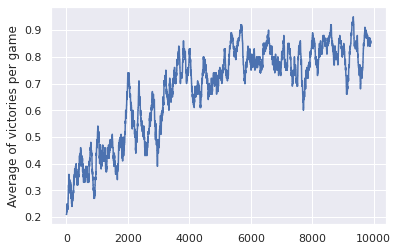

In [11]:
def moving_average_diff(a, n = 100):
    diff    = np.diff(a)
    ret     = np.cumsum(diff, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

plt.plot(moving_average_diff(history))
plt.ylabel('Average of victories per game')
plt.show()

### MODEL TESTING

In [12]:
def test(model):
    #This function lets a pretrained model play the game to evaluate how well it is doing
    global last_frame_time
    plt.ion()
    # Define environment, game
    env = myCatchEnv(grid_size)
    #c is a simple counter variable keeping track of how much we train
    c = 0
    #Reset the last frame time (we are starting from 0)
    last_frame_time = 0
    #Reset score
    points = 0
    #For training we are playing the game 10 times
    for e in range(10):
        loss = 0.
        #Reset the game
        env.reset()
        #The game is not over
        game_over = False
        # get initial input
        input_t = env.observe()
        #display_screen(3,points,input_t)
        c += 1
        while not game_over:
            #The learner is acting on the last observed game screen
            #input_t is a vector containing representing the game screen
            input_tm1 = input_t
            #Feed the learner the current status and get the expected rewards for different actions from it
            q = model.predict(input_tm1)
            #Select the action with the highest expected reward
            action = np.argmax(q[0])
            # apply action, get rewards and new state
            input_t, reward, game_over = env.step(action)
            #Update our score
            points += reward
            display_screen(action,points,input_t)
            c += 1


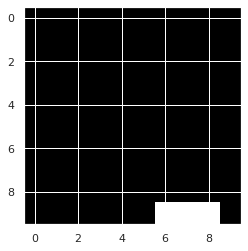

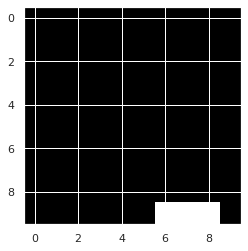

In [13]:
test(model)

## MODEL TRAINING WITH `KERAS-RL` (MBIT RL OPTIONAL EXERCISE)

In [14]:
# Keras-rl is a library for Deep Reinforcement Learning with Keras
from   rl.agents.dqn       import DQNAgent  
from   rl.policy           import BoltzmannQPolicy
from   rl.memory           import SequentialMemory

In [15]:
env_keras     = myCatchEnv(grid_size)

num_actions   = 3   # [move_to_the_left, stand_still, move_to_the_right]
hidden_size   = 100 # size of the hidden layers
grid_size     = 10  # size of the playing field
window_length = 1
input_shape   = (window_length, grid_size**2,)

In [16]:
# Building a simple model:
from keras.layers import Flatten

model = Sequential()
model.add(Flatten(input_shape = input_shape))
model.add(Dense(hidden_size, activation = 'relu'))
model.add(Dense(hidden_size, activation = 'relu'))
model.add(Dense(num_actions, activation = 'relu'))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 303       
Total params: 20,503
Trainable params: 20,503
Non-trainable params: 0
_________________________________________________________________
None


In [17]:
# Configuring and compiling our agent (defining optimizer and metrics):
memory = SequentialMemory(limit = 10000, window_length = 2)
policy = BoltzmannQPolicy()
dqn    = DQNAgent(model               = model, 
                  nb_actions          = num_actions, 
                  memory              = memory, 
                  nb_steps_warmup     = 10, 
                  target_model_update = 1e-2, 
                  policy              = policy)

dqn.compile(Adam(lr = 1e-3), metrics = ['mae'])

In [19]:
# Training the model:

dqn.fit(env_keras, nb_steps = 10000, visualize = True, verbose = 2);

Training for 10000 steps ...


AssertionError: 

In [ ]:
# Testing the model:
dqn.test(env_keras, nb_episodes = 5, visualize = True);